<a href="https://colab.research.google.com/github/hyezzz/KoBert-for-multi-classification/blob/master/KoBERT_for_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 준비 사항

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp            # BERTSentenceTransform : Bert tokenizer 쉽게 가능하게해줌
import numpy as np

from tqdm import tqdm, tqdm_notebook
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

from torchinfo import summary
from torchviz import make_dot
from torch.autograd import Variable
import graphviz 
# maplotlib 한글 설정
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

In [ ]:
# seed 설정
def seed_everything(seed=1062):
    np.random.seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
 
seed_everything(seed=7)

In [ ]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

In [ ]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
##GPU 사용 시
device = torch.device("cuda:0")

### KoBERT  Model, Vocab 불러오기

In [ ]:
# Kobert 모델 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

using cached model
using cached model


In [ ]:
# vocab 사이즈 확인 
vocab

Vocab(size=8002, unk="[UNK]", reserved="['[CLS]', '[SEP]', '[MASK]', '[PAD]']")

In [ ]:
with open("vocab.txt", "w", encoding="utf-8") as f:
    for k, v in vocab.token_to_idx.items():
        if k[0] == '▁':
            k = k.replace('▁', '')
        elif k in ["[UNK]", "[CLS]", "[SEP]", "[MASK]", "[PAD]"]:
            pass
        else:
            k = '##' + k
        f.writelines(k + "\n")

In [ ]:
vocab_list = list(vocab.token_to_idx.keys())
vocab_list

['[UNK]',
 '[CLS]',
 '[SEP]',
 '[MASK]',
 '[PAD]',
 '!',
 "!'",
 '!”',
 '"',
 '#',
 '$',
 '%',
 '%)',
 '&',
 '&#34;',
 "'",
 "'(",
 "',",
 '(',
 '(0',
 '(1',
 '(10',
 '(12',
 '(15',
 '(17',
 '(18',
 '(19',
 '(2',
 '(20',
 '(23',
 '(24',
 '(25',
 '(3',
 '(4',
 '(5',
 '(6',
 '(7',
 '(8',
 '(9',
 '(?)',
 ')',
 ")'",
 '),',
 ')’',
 '*',
 '+',
 ',',
 '-',
 '----------------',
 '-1',
 '-2',
 '-20',
 '-3',
 '-4',
 '.',
 '...',
 '..."',
 "...'",
 '...”',
 '/',
 '0',
 '0%',
 '0%)',
 '0.0',
 '0.00',
 '0.1',
 '0.1%',
 '0.2%',
 '0.3',
 '0.3%',
 '0.4%',
 '0.5',
 '0.5%',
 '0.6',
 '0.6%',
 '0.7',
 '0.7%',
 '0.8',
 '0.8%',
 '00',
 '000.0',
 '00000',
 '01',
 '02',
 '02-',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '0:00:00',
 '1',
 '1%',
 '1%)',
 '1)',
 '1,000',
 '1.3%',
 '1.4%',
 '1.5%',
 '1.6',
 '1.6%',
 '1.7%',
 '1.8',
 '10',
 '100',
 '1000',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '1⁄2',
 '1⁄4',
 '2',
 '2%',
 '2)',
 '2.0',
 '2.3%',
 '2.5',
 '2.5%',
 '2.8%',
 '20',
 '2

# 데이터 로드

In [ ]:
'''
# 데이터 가져오기
path = 'C:/Users/HYEJI/Dropbox/UOS_연구실/khealth_2019'
os.chdir(path)
os.listdir(path)

body = pd.read_excel('clean_body_1_20191118.xlsx')
nutrition = pd.read_excel('clean_nutrition_1_20191118.xlsx')
health = pd.read_excel('clean_health_1_20191118.xlsx')
body.shape, nutrition.shape, health.shape

body['group'] = 0
nutrition['group'] = 1
health['group'] = 2

data = pd.concat([body, nutrition, health], axis = 0).reset_index(drop=True)

# 'USER_ID', 'CNSL_SN', 'group'별로 groupby 후 중복 데이터 삭제
grouped = data.groupby(['USER_ID', 'CNSL_SN', 'group'])

data = pd.DataFrame()
for key, grp in tqdm(grouped):
    grp.drop_duplicates(keep='first', inplace=True, ignore_index=False)
    data = pd.concat([data, grp], axis=0)
data.reset_index(drop=True, inplace=True)

data['message'] = data[['USER_ID','CNSL_SN', 'message', 'group']].groupby(['group', 'CNSL_SN'])['message'].transform(lambda x: '. '.join(x))
data = data[['USER_ID','CNSL_SN', 'message', 'group']].drop_duplicates().reset_index(drop=True)

path = 'C:/Users/HYEJI/Desktop/kobert/kobert/'
data.to_csv(path + 'preprocess_data.csv', index = False, encoding='cp949')
'''

"\n# 데이터 가져오기\npath = 'C:/Users/HYEJI/Dropbox/UOS_연구실/khealth_2019'\nos.chdir(path)\nos.listdir(path)\n\nbody = pd.read_excel('clean_body_1_20191118.xlsx')\nnutrition = pd.read_excel('clean_nutrition_1_20191118.xlsx')\nhealth = pd.read_excel('clean_health_1_20191118.xlsx')\nbody.shape, nutrition.shape, health.shape\n\nbody['group'] = 0\nnutrition['group'] = 1\nhealth['group'] = 2\n\ndata = pd.concat([body, nutrition, health], axis = 0).reset_index(drop=True)\n\n# 'USER_ID', 'CNSL_SN', 'group'별로 groupby 후 중복 데이터 삭제\ngrouped = data.groupby(['USER_ID', 'CNSL_SN', 'group'])\n\ndata = pd.DataFrame()\nfor key, grp in tqdm(grouped):\n    grp.drop_duplicates(keep='first', inplace=True, ignore_index=False)\n    data = pd.concat([data, grp], axis=0)\ndata.reset_index(drop=True, inplace=True)\n\ndata['message'] = data[['USER_ID','CNSL_SN', 'message', 'group']].groupby(['group', 'CNSL_SN'])['message'].transform(lambda x: '. '.join(x))\ndata = data[['USER_ID','CNSL_SN', 'message', 'group']].drop_du

 # 전처리
  - 중복데이터 및 로그 데이터 삭제

In [ ]:
# 전처리 완료한 데이터 가져오기
data = pd.read_csv('preprocess_data.csv', encoding = 'cp949')

In [ ]:
plt_df = data.copy()
plt_df['len_msg'] = data['message'].apply(lambda x: len(x))
plt_df['len_msg'].describe()

count    127831.000000
mean        841.679319
std         672.435498
min           5.000000
25%         383.000000
50%         666.000000
75%        1092.000000
max       12718.000000
Name: len_msg, dtype: float64

<AxesSubplot:title={'center':'CNSL별 문자 길이 boxplot'}, xlabel='len_msg'>

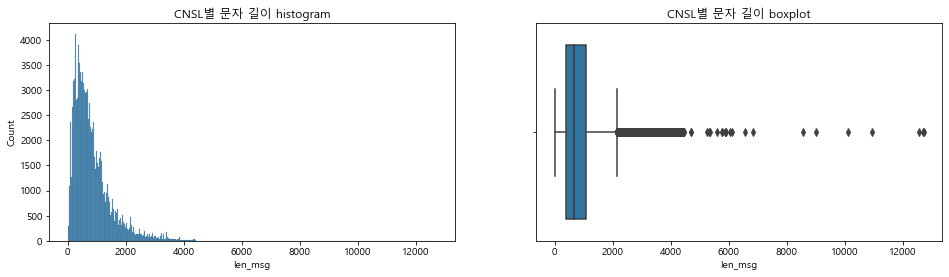

In [ ]:
# 문자 길이 histogram
plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.title('CNSL별 문자 길이 histogram')
sns.histplot(x=plt_df['len_msg'])

plt.subplot(122)
plt.title('CNSL별 문자 길이 boxplot')
sns.boxplot(x = plt_df['len_msg'])

추가적인 전처리가 필요할 것으로 보임
1. log가 나온 것 같은 column들 (cellpadding0 cell0 953 -. height22. col 3 heig...)
  - drop or 한글만 남기기
2. 나눔스퀘어라운드 Bold, 나눔바른고딕
  - drop or 단어만 지우기
  
→ 데이터의 양이 충분하다고 판단 되어서 일단 둘 다 drop하기로 함

In [ ]:
# 추가적인 전처리
data.drop(data.loc[data["message"].map(lambda x: ('cellpadding0' in x) | ('나눔스퀘어라운드' in x) | ('나눔바른고딕' in x) )].index, inplace = True)

plt_df = data.copy()
plt_df['len_msg'] = data['message'].apply(lambda x: len(x))
print(plt_df['len_msg'].describe())

count    127734.000000
mean        840.120031
std         665.716646
min           5.000000
25%         383.000000
50%         665.000000
75%        1092.000000
max        4451.000000
Name: len_msg, dtype: float64


<AxesSubplot:title={'center':'CNSL별 문자 길이 boxplot'}, xlabel='len_msg'>

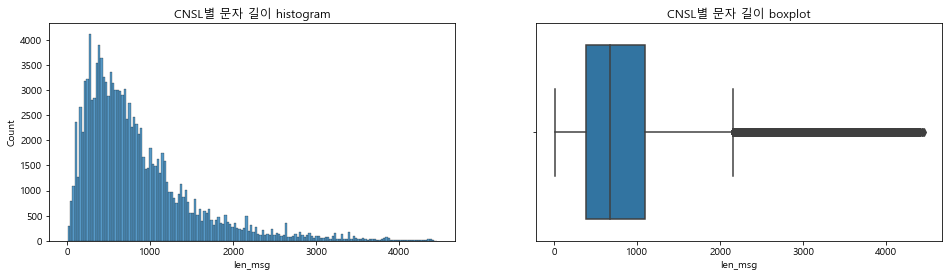

In [ ]:
# 문자 길이 histogram
plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.title('CNSL별 문자 길이 histogram')
sns.histplot(x=plt_df['len_msg'])

plt.subplot(122)
plt.title('CNSL별 문자 길이 boxplot')
sns.boxplot(x = plt_df['len_msg'])

<AxesSubplot:title={'center':'CNSL별 문자 길이 boxplot'}, xlabel='group', ylabel='len_msg'>

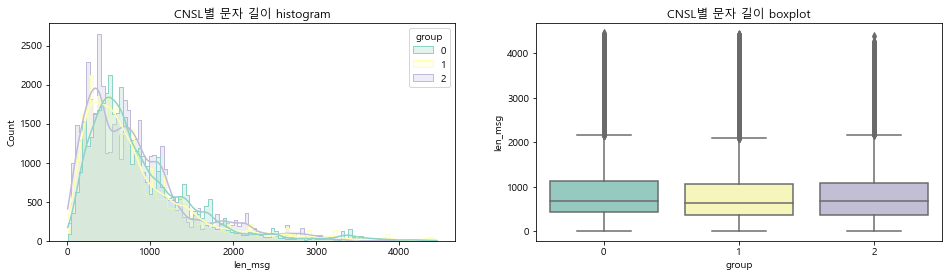

In [ ]:
plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.title('CNSL별 문자 길이 histogram')
sns.histplot(x=plt_df['len_msg'], hue=plt_df['group'], bins = 100, palette='Set3', element="step", kde=True)

plt.subplot(122)
plt.title('CNSL별 문자 길이 boxplot')
sns.boxplot(x=plt_df['group'], y=plt_df['len_msg'], palette='Set3')

# Tokenizing
## 토크나이징 및 input 3가지 만들기
KoBERT source code
```
def get_tokenizer(cachedir='~/kobert/'):
    """Get KoBERT Tokenizer file path after downloading
    """
    model_info = tokenizer
    return download(model_info['url'],
                    model_info['fname'],
                    model_info['chksum'],
                    cachedir=cachedir)

tokenizer = {
    'url':
    'https://kobert.blob.core.windows.net/models/kobert/tokenizer/kobert_news_wiki_ko_cased-ae5711deb3.spiece',
    'fname': 'kobert_news_wiki_ko_cased-1087f8699e.spiece',
    'chksum': 'ae5711deb3'
}
```

**token embedding (1/3 ♪)**
1. get_tokenizer()를 이용하여 한국어 위키 데이터 세트(kobert_news_wiki_ko_cased)를 
    sentencepiece로 사전 훈련한 tokenization model의 path를 가져옴
2. sentencepiece결과를 사전에 학습된 단어사전(vocab)과 대조하여 ids를 받아옴

**segment embedding (2/3 ♪)**
 - Q. task 4개 중 sequence-level task 중 Single sentence classification segment embedding X `(0, 0, 0, ...., 0)`

**Positional embedding (3/3 ♪)**
 - model 내에서 automatical 하게 이루어짐 
 - 모델 [souce code](https://huggingface.co/transformers/_modules/transformers/models/bert/modeling_bert.html#BertModel)

~~~
positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility
~~~

=> BERT Input 3가지 완료

![image.png](attachment:image.png)

![image-3.png](attachment:image-3.png)

![image-2.png](attachment:image-2.png)

In [ ]:
tokenizer = get_tokenizer()   # path: Path to the pre-trained subword tokenization model.

# class gluonnlp.data.BERTSPTokenizer(path, vocab, num_best=0, alpha=1.0, lower=True, max_input_chars_per_word=200)
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)   # tokenizer

tok("잘 유지하고 계십니다.")

using cached model


['▁잘', '▁유지', '하고', '▁계', '십', '니다', '▁', '.']

In [ ]:
tok_list = [tok(i) for i in tqdm(data['message'])]
tok_len_list = [len(i) for i in tqdm(tok_list)]

print('토크나이징 길이의 통계량')
pd.Series(tok_len_list).describe()

100%|█████████████████████████████████████████████████████████████████████| 127734/127734 [00:00<00:00, 2604432.61it/s]


토크나이징 길이의 통계량


count    127734.000000
mean        503.187397
std         402.433474
min           3.000000
25%         224.000000
50%         397.000000
75%         647.000000
max        3147.000000
dtype: float64

<AxesSubplot:title={'center':'CNSL별 token 길이 boxplot'}>

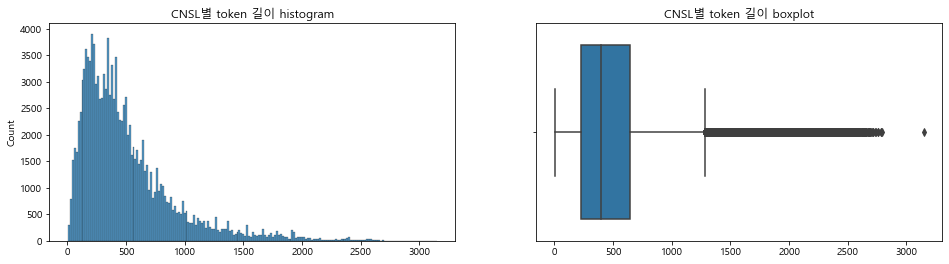

In [ ]:
# token 길이 histogram
plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.title('CNSL별 token 길이 histogram')
sns.histplot(x=tok_len_list)

plt.subplot(122)
plt.title('CNSL별 token 길이 boxplot')
sns.boxplot(x = tok_len_list)

In [ ]:
tok_list_unpack = [element for array in tok_list for element in array]
tok_list = list(set(tok_list_unpack))
print('token list unpack length: ', len(tok_list_unpack))
print('token set length: ', len(tok_list))

token list unpack length:  64274139
token set length:  5762


# 학습 데이터셋 준비

In [ ]:
# train, test 분리
train, test = train_test_split(data, test_size=0.2)

In [ ]:
text = '잘 유지하고 계십니다. 하루에 50분씩 유산소 운동을 해주세요'

# 문장을 token으로 분리 & special tokens 삽입 & token ids가져오기
transform = nlp.data.BERTSentenceTransform(tok, max_seq_length=32, pad=True, pair=False)

indexed_tokens = transform([text])[0]
indexed_tokens = indexed_tokens[:list(indexed_tokens).index(3)+1]

# 비교를 위해 ids로 바뀌기 전  원본 token
tokenized_text = tok(text)
tokenized_text.insert(0, '[CLS]')
tokenized_text.insert(len(tokenized_text), '[SEP]')

for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

# 변환 결과 
print('\n\ntransform 결과 :')
transform([text])

[CLS]             2
▁잘            3,942
▁유지           3,592
하고            7,788
▁계              980
십             6,749
니다            5,772
▁               517
.                54
▁하루           4,937
에             6,896
▁50             612
분             6,416
씩             6,792
▁유            3,574
산             6,516
소             6,607
▁운동           3,514
을             7,088
▁해            4,998
주세요           7,282
[SEP]             3


transform 결과 :


(array([   2, 3942, 3592, 7788,  980, 6749, 5772,  517,   54, 4937, 6896,
         612, 6416, 6792, 3574, 6516, 6607, 3514, 7088, 4998, 7282,    3,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1]),
 array(22),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [ ]:
# map-style : index로 접근
class BERTDataset(Dataset):
    def __init__(self, dataset, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i]) for i in dataset['message']]
        self.labels = [np.int32(i) for i in dataset['group']]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
## Setting parameters
max_len = 128
batch_size = 32
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
data_train = BERTDataset(train, tok, max_len, True, False)
data_test = BERTDataset(test, tok, max_len, True, False)
len(data_train), len(data_test)

(102187, 25547)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=0)
len(train_dataloader), len(test_dataloader)

(3194, 799)

# 모델

```
def get_kobert_model(model_path, vocab_file, ctx="cpu"):
    bertmodel = BertModel.from_pretrained(model_path)
    device = torch.device(ctx)
    bertmodel.to(device)
    bertmodel.eval()
    vocab_b_obj = nlp.vocab.BERTVocab.from_sentencepiece(vocab_file,
                                                         padding_token='[PAD]')
    return bertmodel, vocab_b_obj
```

### `BertModel.from_pretrained(model_path)`

pretrained pytorch model을 인스턴스화 한다

The model is set in evaluation mode by default using 'model.eval()' (Dropout modules are deactivated). 
To train the model, you should first set it back in training mode with 'model.train()'.

- 모델 평가 부분을 보면 model.train()으로 시작함을 확인
 
skt에서 새로운 모델을 만든게 X. Hugging Face에 제공되어 있던 기존의 BERT + 한국어 Wiki 등 (500만개 문장)으로 pre-train..
- oogle에서 공개한 bert의 weight를 동일하게 가지고 있음

### KoBERT Config
```
{
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,	# attention에 대한 dropout prob
  "gradient_checkpointing": false,
  "hidden_act": "gelu",			        # 인코더 및 pooler 계층의 활성화 함수
  "hidden_dropout_prob": 0.1,		    # drop out prob
  "hidden_size": 768,			        # 인코더 및 pooler 계층의 차원
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,		# position embedding의 최대값 
  "model_type": "bert",
  "num_attention_heads": 12,			# Transformer 인코더의 attention head 수
  "num_hidden_layers": 12,		    	# Transformer 인코더의 hidden 레이어 수
  "pad_token_id": 1,
  "type_vocab_size": 2,		        	# segment ids 의 크기 (0, 1 -> 2개가 default)
  "vocab_size": 8002 		        	# BERT 모델의 어휘 크기
}
```


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768, 
                 num_classes=3,               # 다중 분류 
                 dr_rate=None,
                 params=None,
                 encoder_output=None):        # token의 임베딩을 확인하기 위함
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
        
        # token의 임베딩을 확인을 위함
        self.encoder_output = encoder_output
        
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        # token의 임베딩을 확인을 위함 ( _, pooler -> encoder_output, pooler)
        encoder_output, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out), encoder_output

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [ ]:
# model summary
token_ = torch.randint(1, 1000, size=(batch_size, max_len)).type(torch.cuda.LongTensor)
valid_ = torch.randint(max_len, max_len+1, size=(1, batch_size)).type(torch.cuda.LongTensor).squeeze()
segment_ = torch.zeros((batch_size, max_len)).type(torch.cuda.LongTensor)
input_d = [token_, valid_, segment_]

summary(model, input_data = input_d)

Layer (type:depth-idx)                                  Output Shape              Param #
BERTClassifier                                          --                        --
├─BertModel: 1-1                                        [32, 128, 768]            --
│    └─BertEmbeddings: 2-1                              [32, 128, 768]            --
│    │    └─Embedding: 3-1                              [32, 128, 768]            6,145,536
│    │    └─Embedding: 3-2                              [1, 128, 768]             393,216
│    │    └─Embedding: 3-3                              [32, 128, 768]            1,536
│    │    └─LayerNorm: 3-4                              [32, 128, 768]            1,536
│    │    └─Dropout: 3-5                                [32, 128, 768]            --
│    └─BertEncoder: 2-2                                 [32, 128, 768]            --
│    └─BertPooler: 2-3                                  [32, 768]                 --
│    │    └─Linear: 3-6                   

In [ ]:
state_dict = model.state_dict()

for key in state_dict.keys():
    if 'embeddings' in key:
        try:
            print('{:<50} ({}, {})'.format(key, state_dict[key].shape[0], state_dict[key].shape[1]))
        except:
            print('{:<50} ({}, )'.format(key, state_dict[key].shape[0]))

bert.embeddings.position_ids                       (1, 512)
bert.embeddings.word_embeddings.weight             (8002, 768)
bert.embeddings.position_embeddings.weight         (512, 768)
bert.embeddings.token_type_embeddings.weight       (2, 768)
bert.embeddings.LayerNorm.weight                   (768, )
bert.embeddings.LayerNorm.bias                     (768, )


In [ ]:
state_embedding = state_dict['bert.embeddings.word_embeddings.weight'].cpu().numpy()

word_dict = {}
for v, e in zip(vocab_list, state_embedding):
    word_dict[v] = e


vocab_df = pd.DataFrame(word_dict).T

In [ ]:
vocab_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
[UNK],-0.008628,0.015278,0.033778,-0.093347,0.019998,-0.020237,-0.043688,0.040288,-0.023284,-0.048807,...,-0.042467,-0.016914,-0.071751,-0.078698,-0.064119,0.001622,-0.087617,-0.001179,0.086079,-0.019890
[CLS],0.001368,0.027340,0.117263,-0.975448,0.007480,-0.016335,-0.024468,-0.047662,0.009895,-0.119224,...,-0.055022,-0.074711,0.008749,0.074882,0.072774,0.018492,-0.019130,0.042188,-0.058159,-0.072012
[SEP],0.003465,-0.000367,-0.000446,-0.419149,0.019538,0.001243,0.001945,-0.011206,-0.026532,-0.023012,...,0.004671,-0.008200,0.034071,0.034270,0.000109,-0.003008,-0.001619,0.003121,0.010341,-0.003348
[MASK],0.072293,-0.037853,0.027057,-0.324984,-0.025121,0.080477,0.032301,0.062397,0.001907,0.019868,...,0.025568,-0.023945,-0.043171,0.006089,0.008944,0.019942,0.030912,-0.028176,0.016864,-0.081774
[PAD],0.007976,-0.009292,-0.012340,-0.648593,0.025962,0.012335,0.009287,0.004979,-0.001254,-0.011080,...,0.002227,-0.010952,0.008585,0.016734,0.018931,-0.011732,0.014900,0.010090,0.000258,-0.017693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
힌,0.064658,-0.027289,-0.017675,0.020539,0.127499,0.045025,0.020857,-0.047814,0.097381,-0.143893,...,-0.027449,0.021552,0.126421,0.021844,0.003017,0.032728,0.063559,-0.009611,-0.003149,0.035869
힐,-0.084372,-0.152848,-0.062077,-0.000634,0.161037,0.093466,-0.068220,-0.096997,0.061676,-0.087537,...,-0.123299,0.021858,0.082042,0.110653,-0.113111,-0.009206,0.045100,-0.007087,-0.080756,0.057284
힐링캠프,-0.086310,-0.078166,-0.033516,0.038783,-0.131496,-0.047548,-0.002012,-0.087614,0.166489,0.103608,...,-0.088590,-0.131570,-0.038094,0.077120,-0.105055,-0.063566,-0.056019,-0.111181,0.085566,0.144649
힘,0.111376,-0.037551,-0.058745,0.071265,0.098227,-0.012983,0.039120,-0.063552,-0.050664,-0.085347,...,-0.135468,0.132594,0.037122,-0.010465,0.061829,0.032756,0.013890,-0.128845,0.054569,0.084309


### 임베딩 heatmap으로 표현하기
 - Q. 모델 돌린 후 달라질까?

In [ ]:
# 아까 예제 불러오기
print('----------------- original text -----------------\n')
print(text, '\n\n')

print('----------------- tokenized text -----------------\n')
print(tokenized_text, '\n\n')

print('----------------- tokenized index -----------------\n')
print(indexed_tokens)

----------------- original text -----------------

잘 유지하고 계십니다. 하루에 50분씩 유산소 운동을 해주세요 


----------------- tokenized text -----------------

['[CLS]', '▁잘', '▁유지', '하고', '▁계', '십', '니다', '▁', '.', '▁하루', '에', '▁50', '분', '씩', '▁유', '산', '소', '▁운동', '을', '▁해', '주세요', '[SEP]'] 


----------------- tokenized index -----------------

[   2 3942 3592 7788  980 6749 5772  517   54 4937 6896  612 6416 6792
 3574 6516 6607 3514 7088 4998 7282    3]


In [ ]:
test_dict = {}

for t, ids in zip(tokenized_text, indexed_tokens):
    print(ids)
    test_dict[t] = state_embedding[ids-1]


test_df = pd.DataFrame(test_dict).T
test_df.head()

2
3942
3592
7788
980
6749
5772
517
54
4937
6896
612
6416
6792
3574
6516
6607
3514
7088
4998
7282
3


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
[CLS],0.001368,0.027340,0.117263,-0.975448,0.007480,-0.016335,-0.024468,-0.047662,0.009895,-0.119224,...,-0.055022,-0.074711,0.008749,0.074882,0.072774,0.018492,-0.019130,0.042188,-0.058159,-0.072012
▁잘,-0.077625,0.006853,-0.050031,0.032831,-0.072303,-0.137501,0.032491,0.034961,-0.110782,0.093458,...,-0.160756,0.024603,0.041127,0.002548,0.076318,-0.057076,-0.059606,0.031179,0.040838,-0.040398
▁유지,-0.106423,-0.033583,-0.077084,-0.033616,-0.063476,0.039857,-0.008615,-0.010420,0.080759,-0.013949,...,0.004826,-0.052977,0.161587,0.010103,0.048661,-0.023852,-0.017749,-0.048495,-0.054590,-0.078921
하고,0.024842,0.018164,0.029798,-0.048367,0.153731,0.018004,0.084673,-0.014383,-0.041035,0.005901,...,-0.016227,-0.048670,0.015435,0.068309,-0.038344,-0.017124,0.088567,-0.000464,-0.024231,0.043018
▁계,0.012839,0.087173,-0.025755,0.036842,-0.002596,-0.001168,-0.091017,0.132792,-0.014720,-0.101460,...,0.019713,0.155935,-0.079887,-0.013058,0.006996,-0.039455,0.056154,-0.058382,0.107477,-0.094050


C:\Users\HYEJI\anaconda3\envs\bert\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\HYEJI\anaconda3\envs\bert\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

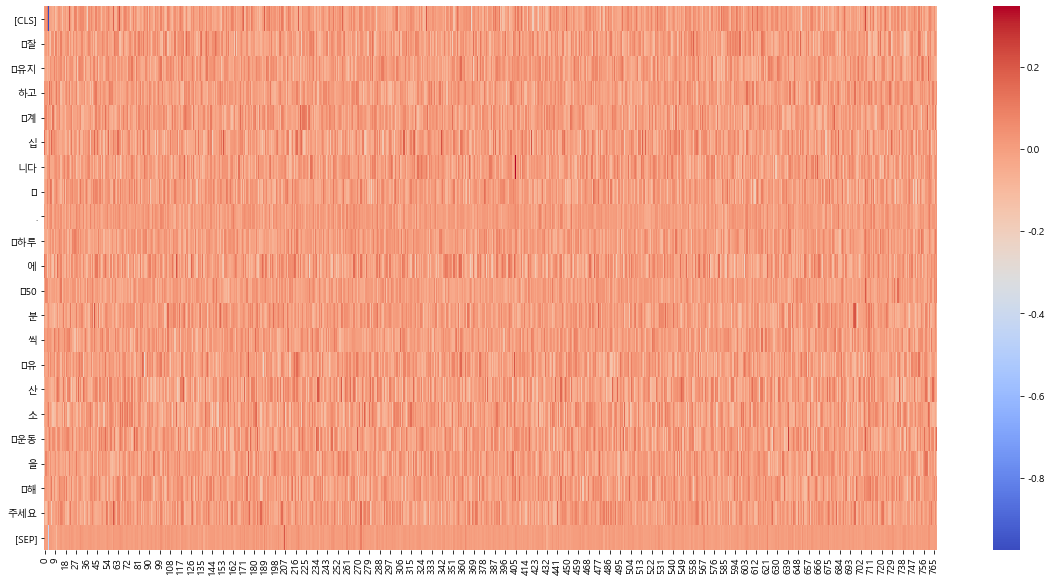

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(test_df, cmap = 'coolwarm')

<AxesSubplot:>

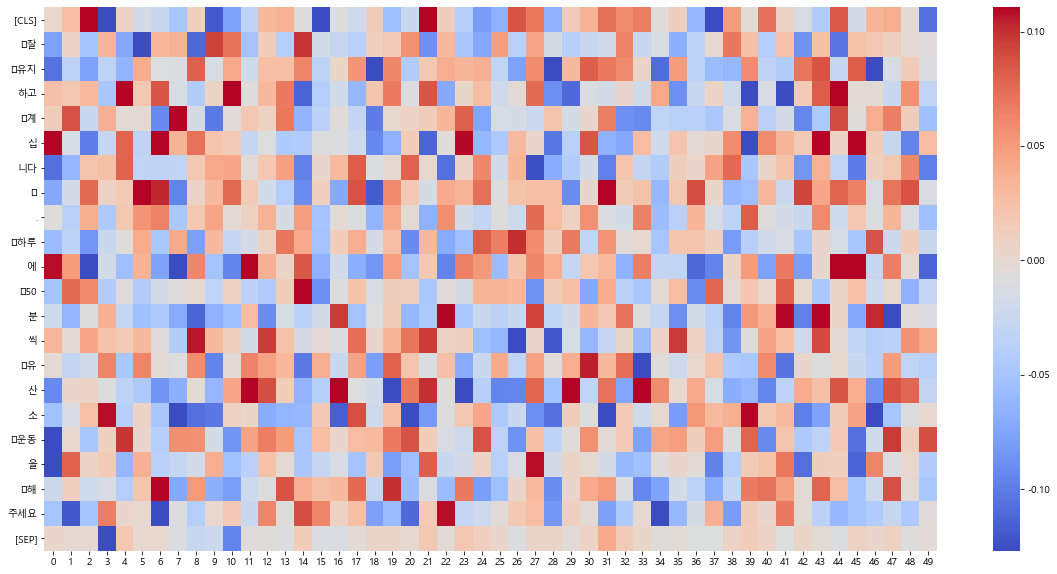

In [ ]:
# 가시적이지 못해서 극값을 분위수로 바꾸고 column을 50개까지만 확인하기로 함
plt.figure(figsize=(20, 10))
sns.heatmap(test_df.iloc[:, :50], cmap = 'coolwarm', robust=True)

In [ ]:
'''
# model visualization by torchviz &graphviz
dot = make_dot(model(token_, valid_, segment_), params=dict(model.named_parameters()))
dot.format = 'png'
dot.render("model_graph")

# model visualization by netron
## 학습 파라미터 불러오기 - model , optimizer
PATH = './weights/'
checkpoint = torch.load(PATH + 'all.tar')   # dict 불러오기
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

## model 을 onnx 파일로 저장
params = model.state_dict()

torch.onnx.export(model, (token_, valid_, segment_), PATH+"model2.onnx", opset_version=11)

## CUDA out of memory.
torch.cuda.empty_cache()
'''

'\n# model visualization by torchviz &graphviz\ndot = make_dot(model(token_, valid_, segment_), params=dict(model.named_parameters()))\ndot.format = \'png\'\ndot.render("model_graph")\n\n# model visualization by netron\n## 학습 파라미터 불러오기 - model , optimizer\nPATH = \'./weights/\'\ncheckpoint = torch.load(PATH + \'all.tar\')   # dict 불러오기\nmodel.load_state_dict(checkpoint[\'model\'])\noptimizer.load_state_dict(checkpoint[\'optimizer\'])\n\n## model 을 onnx 파일로 저장\nparams = model.state_dict()\n\ntorch.onnx.export(model, (token_, valid_, segment_), PATH+"model2.onnx", opset_version=11)\n\n## CUDA out of memory.\ntorch.cuda.empty_cache()\n'

In [ ]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},    # 일반 파라메터에는 l2 regularization lambda = 0.01
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}        # Layernorm, bias 는 regularization을 주지 않음
]

In [ ]:
#optimizer = AdamW(model.parameters(), lr=learning_rate)
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)
print(t_total, warmup_step)

15970 1597


# 학습

In [ ]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
print('사용가능한 gpu개수 \t', torch.cuda.device_count())
print('사용하는 gpu 이름 \t', torch.cuda.get_device_name(0))
print('gpu 사용 여부 \t\t', torch.cuda.is_available())
print('학습을 진행하는 기기 \t', device)
    

사용가능한 gpu개수 	 1
사용하는 gpu 이름 	 GeForce RTX 2080 Ti
gpu 사용 여부 		 True
학습을 진행하는 기기 	 cuda:0


In [ ]:
!nvidia-smi

Thu Jun  3 19:02:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.09       Driver Version: 461.09       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208... WDDM  | 00000000:26:00.0  On |                  N/A |
| 30%   36C    P2    65W / 250W |   2456MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()

In [ ]:
enc_vec_list_train = []
enc_vec_list_test = []
for e in range(1):  # num_epochs
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(train_dataloader):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out, enc_vec = model(token_ids, valid_length, segment_ids)
        enc_vec_list_train.append(enc_vec)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
        break
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out, enc_vec = model(token_ids, valid_length, segment_ids)
        enc_vec_list_test.append(enc_vec)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

epoch 1 batch id 1 loss 1.2003567218780518 train acc 0.25
epoch 1 train acc 0.25


RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 11.00 GiB total capacity; 8.24 GiB already allocated; 26.11 MiB free; 8.34 GiB reserved in total by PyTorch)

In [ ]:
enc_vec_list_train[0].shape

torch.Size([32, 128, 768])

In [ ]:
len(enc_vec_list_train)

1

# 모델 저장

In [ ]:
'''
PATH = './weights/'
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, PATH + 'all.tar')
'''

### 아까 text 의 input 임베딩이 변했을까? -> No
- bert model에 backward X
- 각 Encoder의 output을 모두 그 단어의 embedding으로 사용할 수 있다

In [ ]:
## 학습 파라미터 불러오기 - model , optimizer
PATH = './weights/'
checkpoint = torch.load(PATH + 'all.tar')   # dict 불러오기
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
# 아까 예제 불러오기
print('----------------- original text -----------------\n')
print(text, '\n\n')

print('----------------- tokenized text -----------------\n')
print(tokenized_text, '\n\n')

print('----------------- tokenized index -----------------\n')
print(indexed_tokens)

In [ ]:
state_dict = model.state_dict()

for key in state_dict.keys():
    try:
        print('{:<60} ({}, {})'.format(key, state_dict[key].shape[0], state_dict[key].shape[1]))
    except:
        print('{:<60} ({}, )'.format(key, state_dict[key].shape[0]))

In [ ]:
state_dict['bert.encoder.layer.11.output.LayerNorm.weight'].cpu().numpy().shape

In [ ]:
state_dict = model.state_dict()
# embedding 결과 값으로 바꿈
state_embedding = state_dict['bert.encoder.layer.11.output.LayerNorm.weight'].cpu().numpy()

test_dict = {}
for t, ids in zip(tokenized_text, indexed_tokens):
    print(ids)
    test_dict[t] = state_embedding[ids-1]


test_df = pd.DataFrame(test_dict).T
test_df.head()

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(test_df, cmap = 'coolwarm')

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(test_df, cmap = 'coolwarm', robust=True)

In [ ]:
# 가시적이지 못해서 극값을 분위수로 바꾸고 column을 50개까지만 확인하기로 함
plt.figure(figsize=(20, 10))
sns.heatmap(test_df.iloc[:, :50], cmap = 'coolwarm', robust=True)